<a href="https://colab.research.google.com/github/kostique23/kostique23.github.io/blob/main/(%D0%9A%D1%83%D0%BB%D0%B5%D0%B1%D1%8F%D0%BA%D0%B8%D0%BD_%D0%9A_%D0%94_)_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%961_(%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовительная часть

Набор данных Quick Draw представляет собой коллекцию из 50 миллионов рисунков в 345 категориях, созданных участниками игры "Quick, Draw!".
Чтобы облегчить задачу и обучение я создал текстовый файл с списком из 50-ти рандомных классов по Quick, Draw!

In [ ]:
# Открываем файл и пересоздаем список из заготовленных рандомных классов

f = open("spisok.txt","r")
classes = f.readlines()
f.close()

In [ ]:
# Обрабатываем список (удаляем символ новой строки, заменяем пробелы на символ "_")

classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [ ]:
# Создаем папку "data", в которой будут сохранены классы.

!mkdir data

In [ ]:
# Воспользуемся модулем "urllib.request" для открытия URL-адресов
# Создадим функцию "download", которая будет выполнять загрузку файлов.
# В функцию "download" специально добавлено "print(path)". Это просто вывод загружающихся классов, чтобы не за пустым кружком выполнения строки следить)

import urllib.request
def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:
        cls_url = c.replace('_', '%20')
        path = base+cls_url+'.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/penguin.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broccoli.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/shoe.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/mailbox.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/aircraft%20carrier.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hockey%20puck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/saxophone.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pants.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/teapot.npy
https://storage.googleapis.com/quickdraw_

## Импорт нужных библиотек

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import time

## Загрузка данных

In [ ]:
# С помощью функции load_data выполним загрузку данных из файлов ".npy" в переменные "x_train", "y_train", "x_test", "y_test" и "class_names"

def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]


    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
# Выводим размер обучающей выборки

print(len(x_train))

156800


## Визуализация данных

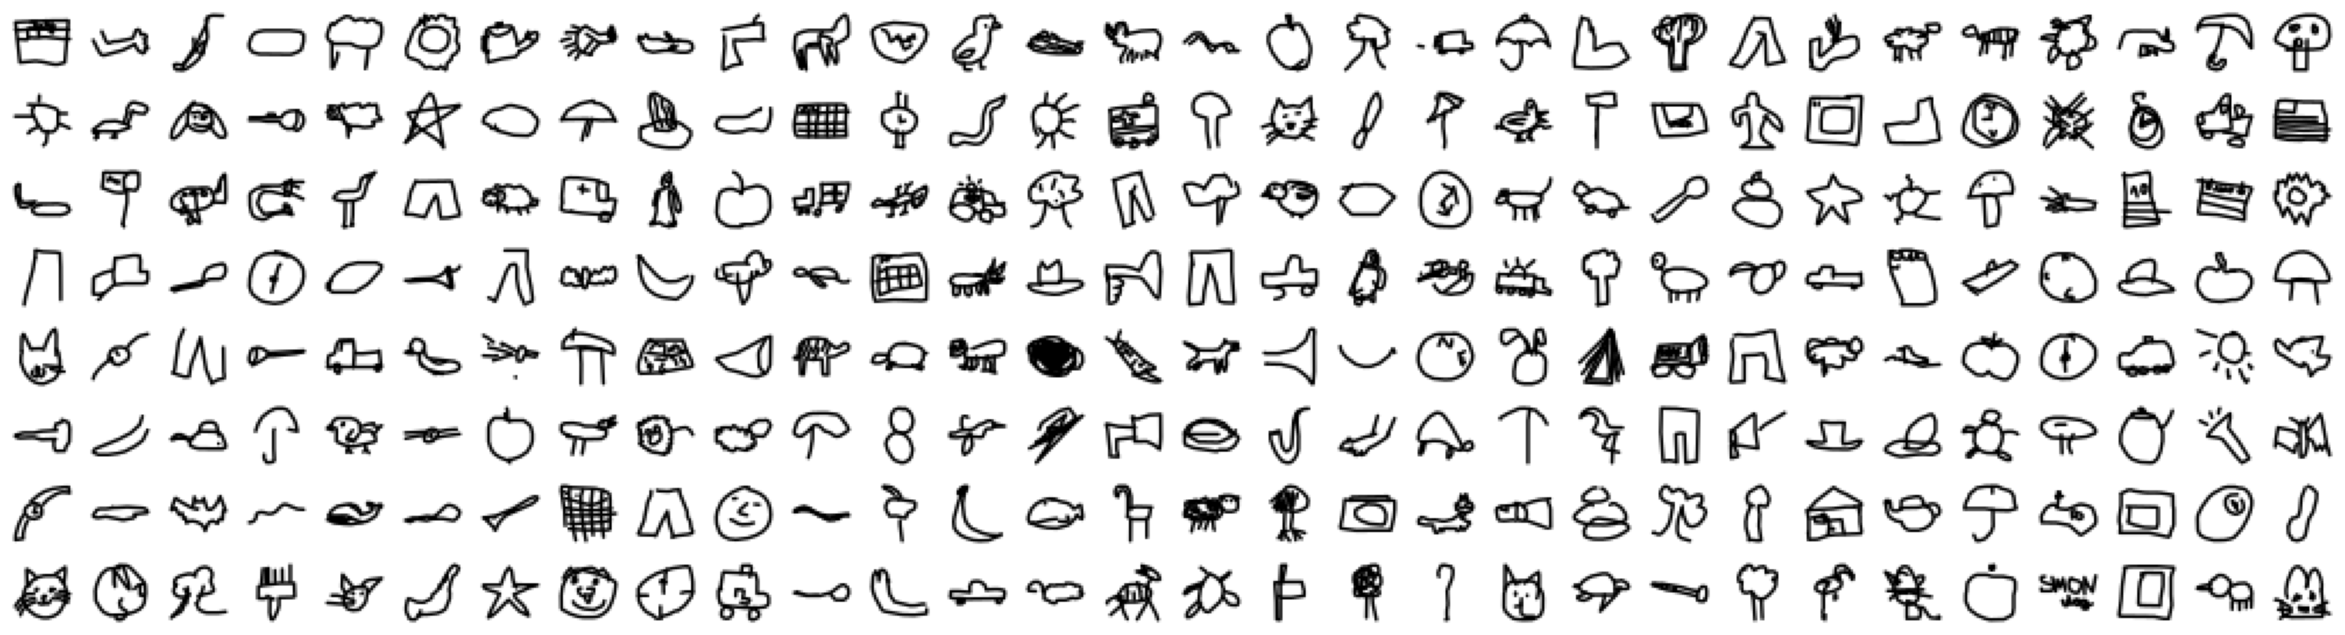

In [ ]:
# Визуализируем рандомные изображения из обучающей выборки

num_images_to_visualize = 240
selected_indices = np.random.choice(len(x_train), num_images_to_visualize, replace=False)
subset_images = x_train[selected_indices]

plt.figure(figsize=(30, 8))
for i in range(num_images_to_visualize):
    plt.subplot(8, 30, 1 + i)
    plt.axis('off')
    plt.imshow(subset_images[i].reshape((28, 28)), cmap='gray_r')

## Предобработка данных для обучения

In [ ]:
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Модель  сверточной нейронной сети (CNN)

In [ ]:
# В данной модели задействовано 3 сверточных слоя "Convolution2D", 3 слоя максимального пулинга "MaxPooling2D" и 2 полносвязных слоя "Dense"

model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(49, activation='softmax'))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])

## Обучение модели

In [ ]:
start = time.time()

model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

end = time.time()
elapsed_time = end - start
minutes = int(elapsed_time // 60)
second = int(elapsed_time % 60)

Epoch 1/5
552/552 - 101s - loss: 1.9212 - top_k_categorical_accuracy: 0.7708 - val_loss: 1.3840 - val_top_k_categorical_accuracy: 0.8737 - 101s/epoch - 183ms/step
Epoch 2/5
552/552 - 101s - loss: 1.2218 - top_k_categorical_accuracy: 0.8945 - val_loss: 1.1628 - val_top_k_categorical_accuracy: 0.9038 - 101s/epoch - 183ms/step
Epoch 3/5
552/552 - 98s - loss: 1.0501 - top_k_categorical_accuracy: 0.9132 - val_loss: 1.0492 - val_top_k_categorical_accuracy: 0.9146 - 98s/epoch - 178ms/step
Epoch 4/5
552/552 - 97s - loss: 0.9505 - top_k_categorical_accuracy: 0.9239 - val_loss: 0.9826 - val_top_k_categorical_accuracy: 0.9197 - 97s/epoch - 176ms/step
Epoch 5/5
552/552 - 103s - loss: 0.8846 - top_k_categorical_accuracy: 0.9302 - val_loss: 0.9095 - val_top_k_categorical_accuracy: 0.9285 - 103s/epoch - 187ms/step


## Оценка точности модели

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Время выполнения обучения модели: {minutes} минут {second} секунд")
print(f"Точность на тестовой выборке: {int(score[1] * 100)}%")

Время выполнения обучения модели: 8 минут 25 секунд
Точность на тестовой выборке: 92%


## Проверка работы модели

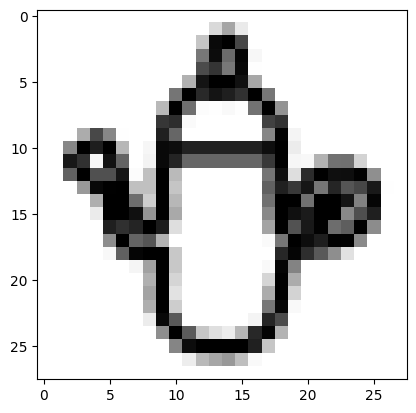

1/1 [==============================] - 0s 30ms/step
Класс: teapot
Класс: sea_turtle
Класс: cat
Класс: penguin
Класс: rabbit


In [ ]:
#@title Выводим рандомное изображение
# пропускаем его через обученную модель для получения предсказаний
# через "Softmax" получаем вероятность для каждого класса
# выбираем топ-5 классов с наивысшей вероятностью
# выводим имена классов

idx = randint(0, len(x_test))
img = x_test[idx]

plt.imshow(img.squeeze(), cmap='gray_r')
plt.show()

pred = model.predict(np.expand_dims(img, axis=0))[0]
softmax_pred = np.exp(pred) / np.sum(np.exp(pred))
ind = (-softmax_pred).argsort()[:5]


for i in range(len(ind)):
    class_idx = ind[i]
    probability = softmax_pred[class_idx] * 100
    class_name = class_names[class_idx]
    print(f"Класс: {class_name}")

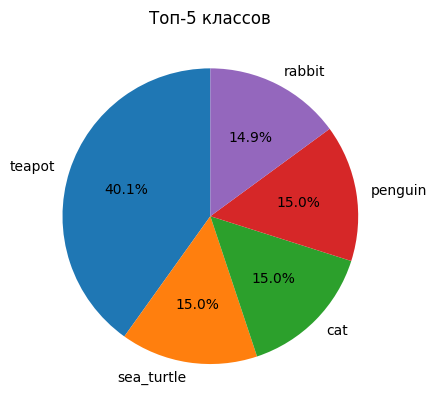

In [ ]:
#@title Выводим круговую диаграмму
# строим диаграмму с именами классов и соответствующими вероятностями в процентах для наших топ-5 классов

labels = [class_names[i] for i in ind]
sizes = [softmax_pred[i] * 100 for i in ind]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Топ-5 классов')

plt.show()
